In [1]:
!pip install pytorch_lightning
!pip install transformers

     |████████████████████████████████| 256kB 4.5MB/s 
     |████████████████████████████████| 829kB 14.4MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=3b1e63dc158a4924d3767097702e3296b7120cb36a2e9ce974a950c24c270fd6
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0
     |████████████████████████████████| 675kB 4.4MB/s 
     |████████████████████████████████| 3.8MB 11.4MB/s 
     |████████████████████████████████| 1.1MB 45.5MB/s 
     |████████████████████████████████| 890kB 56.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=b6d892ebd82498ddc62b83bb934166e5a3954247cc543978278603f32aa847ad
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce3

In [2]:
!nvidia-smi

Sun Jun  7 21:39:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from transformers import *
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
def seed_all(seed):
  random.seed(seed)
  torch.manual_seed(seed)
  np.random.seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
seed_all(34)


In [0]:
#Model FineTune
class T5Lightning(pl.LightningModule):
  def __init__(self, hparams):
    super(T5Lightning, self).__init__()
    self.hparams = hparams
    self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
    self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
  
  def is_logger(self):
    return self.trainer.proc_rank <= 0
  
  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        lm_labels=lm_labels,
    )

  def _step(self, batch):
    lm_labels = batch["target_ids"]
    lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        lm_labels=lm_labels,
        decoder_attention_mask=batch['target_mask']
    )

    loss = outputs[0]

    return loss

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)

    tensorboard_logs = {"train_loss": loss}
    return {"loss": loss, "log": tensorboard_logs}
  
  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    return {"val_loss": loss}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    tensorboard_logs = {"val_loss": avg_loss}
    return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]
  
  def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
    if self.trainer.use_tpu:
      xm.optimizer_step(optimizer)
    else:
      optimizer.step()
    optimizer.zero_grad()
    self.lr_scheduler.step()
  
  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", args=self.hparams)
    dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="val", args=self.hparams)
    return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)


In [0]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      # Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      # Log and save results to file
      output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))

In [0]:
args_dict = dict(
    data_dir="", # path for data files
    output_dir="", # path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_seq_length=512,
    learning_rate=2e-4,
    weight_decay=0.01,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=4,
    gradient_accumulation_steps=16,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False, # if you waant to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=34,
)

In [0]:
mkdir t5_segtiment

In [25]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
tokenizer.tokenize("somewhat positive </s>")

['▁somewhat', '▁positive', '</s>']

In [11]:
args_dict.update({'data_dir': 'data', 'output_dir': './t5_sentiment', 'num_train_epochs':2})
args = argparse.Namespace(**args_dict)
model = T5Lightning(args)
model.model

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

In [12]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=args.output_dir, prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=5
)
train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
    tpu_cores=8,
)
trainer = pl.Trainer(**train_params)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]


In [13]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"doanquanvietnamca","key":"5c44ad334dfc534e12d04dc8373e0440"}'}

In [14]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pip install kaggle
!kaggle competitions download -c sentiment-analysis-on-movie-reviews

  0% 0.00/1.28M [00:00<?, ?B/s]
100% 1.28M/1.28M [00:00<00:00, 89.7MB/s]
  0% 0.00/494k [00:00<?, ?B/s]
100% 494k/494k [00:00<00:00, 153MB/s]
  0% 0.00/583k [00:00<?, ?B/s]
100% 583k/583k [00:00<00:00, 192MB/s]


In [16]:
!unzip  train.tsv.zip
!unzip  test.tsv.zip

Archive:  train.tsv.zip
  inflating: train.tsv               
Archive:  test.tsv.zip
  inflating: test.tsv                


In [19]:
!mkdir data
!mv *.tsv data

mkdir: cannot create directory ‘data’: File exists


In [0]:
train = pd.read_csv("data/train.tsv" ,sep='\t', header=0)
test = pd.read_csv("data/test.tsv", sep='\t', header=0)

In [22]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


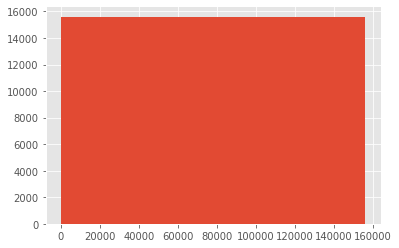

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import seaborn
plt.style.use('ggplot')
np.random.seed(0)
train['PhraseId'].hist()


In [0]:
def convert(t):
  if t==0:
    return 'negative </s>'
  elif t==1:
    return "somewhat negative </s>"
  elif t==2:
    return "neutral </s>"
  elif t==3:
    return "somewhat positive </s>"
  else:
    return "positive </s>"
train['target'] = train['Sentiment'].apply(convert)


In [0]:
from sklearn.model_selection import train_test_split
df = train[['Phrase', 'target']]
df.columns = ['text', 'target']
train ,valid = train_test_split(df, test_size=0.2, random_state = 42)
train.to_csv("data/train.csv")
valid.to_csv("data/val.csv")

In [44]:
train.head()

,text,target
22538,cheesy,somewhat negative </s>
99237,unintentionally -RRB-,neutral </s>
60377,will need all the luck they can muster just fi...,negative </s>
128317,somewhere between Sling Blade and South of Hea...,neutral </s>
20776,reminds at every turn of Elizabeth Berkley 's ...,somewhat negative </s>


In [46]:
%%time
class ToxicDataset(Dataset):
  def __init__(self, tokenizer, data_dir, type_path,  max_len=512):
    self.path = os.path.join(data_dir, type_path + '.csv')

    self.data_column = ["text"]
    self.class_column = ['target']
    self.data = pd.read_csv(self.path)
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []
    self._build()
  def __len__(self):
    return len(self.inputs)
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
    target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
  
  def _build(self):
    for idx in range(self.data.shape[0]):
      input_ =  self.data.loc[idx][self.data_column]
      target =  self.data.loc[idx, self.class_column]
      input_ = str(input_) + ' </s>'
      
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [input_], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
      )
      tokenized_targets = self.tokenizer.batch_encode_plus(
          [str(target)], max_length=3, pad_to_max_length=True, return_tensors="pt"
      )
      self.inputs.append(tokenized_inputs)
      self.targets.append(tokenized_targets)
tokenizer = T5Tokenizer.from_pretrained('t5-base')

dataset = ToxicDataset(tokenizer, 'data', 'train', 128)
len(dataset)


CPU times: user 5min 29s, sys: 1.54 s, total: 5min 31s
Wall time: 5min 31s


In [0]:
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [0]:
it = iter(loader)

In [49]:
batch = next(it)
batch["source_ids"].shape

torch.Size([32, 128])

In [0]:
def get_dataset(tokenizer, type_path, args):
  return ToxicDataset(tokenizer=tokenizer, data_dir=args.data_dir, type_path=type_path,  max_len=args.max_seq_length)


In [0]:
trainer.fit(model)


    | Name                                                                  | Type                       | Params
-----------------------------------------------------------------------------------------------------------------
0   | model                                                                 | T5ForConditionalGeneration | 222 M 
1   | model.shared                                                          | Embedding                  | 24 M  
2   | model.encoder                                                         | T5Stack                    | 109 M 
3   | model.encoder.block                                                   | ModuleList                 | 84 M  
4   | model.encoder.block.0                                                 | T5Block                    | 7 M   
5   | model.encoder.block.0.layer                                           | ModuleList                 | 7 M   
6   | model.encoder.block.0.layer.0                                         | T5LayerSe

In [0]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [0]:
outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

dec = [tokenizer.decode(ids) for ids in outs]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]

In [0]:
import textwrap
for i in range(12):
    c = texts[i]
    lines = textwrap.wrap("text:\n%s\n" % c, width=100)
    print("\n".join(lines))
    print("\nActual sentiment: %s" % targets[i])
    print("predicted sentiment: %s" % dec[i])
    print("=====================================================================\n")

text: text SA MP. Steel and ferrochrome industry on verge... Name: 1504, dtype: object

Actual sentiment: negative
predicted sentiment: positive

text: text Wild land fires.. Here I come.?????? Name: 1505, dtype: object

Actual sentiment: positive
predicted sentiment: negative

text: text @MissDaOh and if she had a screaming baby you... Name: 1506, dtype: object

Actual sentiment: negative
predicted sentiment: negative

text: text US wont upgrade its infrastructure? http://t.c... Name: 1507, dtype: object

Actual sentiment: positive
predicted sentiment: negative

text: text #TBT to that time my best friend and I panicke... Name: 1508, dtype: object

Actual sentiment: negative
predicted sentiment: negative

text: text SCREAMING IN 22 DIFFERENT LANGUAGES http://t.c... Name: 1509, dtype: object

Actual sentiment: negative
predicted sentiment: negative

text: text *to Luka* They should all die! All of them! Ev... Name: 1510, dtype: object

Actual sentiment: negative
predicted sentiment: ne

In [0]:
from tqdm import tqdm
seed_all(34)
dataset = ToxicDataset(tokenizer, 'data', 'val', 512)
loader = DataLoader(dataset, batch_size=32, num_workers=4)
model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
  
  outputs.extend(dec)
  targets.extend(target)

100%|██████████| 48/48 [00:30<00:00,  1.58it/s]


In [0]:
from sklearn import metrics
metrics.accuracy_score(targets, outputs)

0.7340774786605384

In [0]:
from tqdm import tqdm
dataset = ToxicDataset(tokenizer, 'data', 'test', 512)
loader = DataLoader(dataset, batch_size=32, num_workers=4)
model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
  
  outputs.extend(dec)
  targets.extend(target)

KeyError: ignored